# Use "other_layer" since it corrects some mistakes from this notebook

In [10]:
# Importing relevant libraries and defining the Net class (same class with which the networks were generated)
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pickle
from numpy.random import RandomState
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from typing import Any, Callable, Optional, Tuple
from torchvision import datasets, transforms
import torch.nn.functional as F
import quadprog

In [11]:
# Network class
k=1
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Sequential(nn.Conv2d(3, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True)), nn.Sequential(nn.Conv2d(16*k, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True))] 
        self.layers+=[nn.Sequential(nn.Conv2d(16*k, 32*k,  kernel_size=3, stride=2),  nn.BatchNorm2d(32*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True)),nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 64*k,  kernel_size=3, stride=2), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=3, padding='valid'), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=1), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+= [nn.AdaptiveAvgPool2d((1,1))]
        self.fc = nn.Linear(64*k, 10)
    
    def forward(self, x, acts_only=False,all_act=False):
        all_acts = []
        for i in range(len(self.layers)):
            all_acts.append(x)
            x = self.layers[i](x)

        x = self.fc(x.view(-1, 64*k))

        if all_act:
            # all_cts does not return the final output of the network
            return all_acts, x
        return x
    
#     def forward_embed(self, x, layer_idx = -1):
#         if layer_idx != -1:
#             for i in range(len(self.layers[:layer_idx])): # layer index starts at 0
#                 x = self.layers[i](x)
#         else:
#             for i in range(len(self.layers)):
#                 x = self.layers[i](x)
                
#         return x
    def forward_embed(self, x, layer_idx = -1):
        for i in range(len(self.layers[:layer_idx])):
             x = self.layers[i](x)
                
        return x
    
# Defining linear CKA
class LinCKA(nn.Module):
    def __init__(self, n=1000):
        super(LinCKA, self).__init__()
        self.resetK(n)
    
    def resetK(self,n):
        unit = torch.ones([n, n])
        I = torch.eye(n)
        H = I - unit / n
        H = H.cuda()
        self.H = H.cuda()
        self.n = n

    def centering(self, K):
        H = self.H
        return torch.matmul(torch.matmul(H, K), H) 

    def linear_HSIC(self, X, Y):
        L_X = torch.matmul(X, X.T)
        L_Y = torch.matmul(Y, Y.T)
        return torch.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self,X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = torch.sqrt(self.linear_HSIC(X, X))
        var2 = torch.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2),var1,var2

    def forward(self, X,Y):
        if len(X) != self.n:
            self.resetK(len(X))
        return self.linear_CKA(X,Y)

In [12]:
# # Import data 
# from torchvision import datasets, transforms
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])

# transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 
# transform_train =  transforms.Compose([transforms.ToTensor(), normalize]) 
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")

# ##### Cifar Data
# cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
# cifar_data_test = datasets.CIFAR10(root='.',train=False, transform=transform_val, download=True)
# n=10000
# val_loaderx = torch.utils.data.DataLoader(cifar_data_test,
#                                            batch_size=n, 
#                                            shuffle=False)
# data, labels = iter(val_loaderx).next()
# data = data.to(device)

# train_loaderx = torch.utils.data.DataLoader(cifar_data,
#                                            batch_size=50000, 
#                                            shuffle=False)
# train_data, train_labels = iter(train_loaderx).next()
# train_data = train_data.to(device)
# train_labels = train_labels.detach().cpu().numpy()

In [13]:
# Importing the saved networks
PATH='net_kornblith/net_kornblith_'

# net_rand1 = Net()
# net_rand1.load_state_dict(torch.load(PATH+'random_1.zip'))
# net_rand1.eval()
# net_rand1.cuda()

# net_rand2 = Net()
# net_rand1.load_state_dict(torch.load(PATH+'random_2.zip'))
# net_rand2.eval()
# net_rand2.cuda()

net_all1 = Net()
net_all1.load_state_dict(torch.load(PATH+'all_1.zip'))
net_all1.eval()
net_all1.cuda()

# net_all2 = Net()
# net_all2.load_state_dict(torch.load(PATH+'all_2.zip'))
# net_all2.eval()
# net_all2.cuda()

# net_mem_s1 = Net()
# net_mem_s1.load_state_dict(torch.load(PATH+'mem_1_set1.zip'))
# net_mem_s1.eval()
# net_mem_s1.cuda()

# net_mem_s2 = Net()
# net_mem_s2.load_state_dict(torch.load(PATH+'mem_2_set2.zip'))
# net_mem_s2.eval()
# net_mem_s2.cuda()

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

# Split and train experiment

## Functions

In [5]:
def get_activations_by_class(data, labels):
    indexes = []
    datapoints = []
    
    for label in range(10): #for label in set(labels): 
        indexes.append(np.where(labels==label))
        datapoints.append(data[indexes[-1]])
    
    return datapoints, np.array(indexes).squeeze()

def split_class_clusters(data, indexes, d, W, n_clusters, split_constant, ortho_d = True, experiment = 'one_class_one_point'):
    # data should be of shape n x d (n examples, d features)
    # d is the random direction vector
    # W comes from lin_svc.coef_ (n_classes, n_features) corresponding to the normal vectors to the decision hyperplanes
    data_ = np.copy(data)
    
    if ortho_d:
        Q, R = np.linalg.qr(W.T)
        d_ = d.reshape([1,np.max(d.shape)])
        d_ -= np.matmul(d_, np.matmul(Q, Q.T))
#     print("Direction after removing components: {}".format(d_))
    else:
        d_ = d
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
    
    translations = np.zeros(data_.shape[0])
    
    idxs = []
    separators = np.linspace(min_,max_,n_clusters+1)
    if 'one_point' in experiment: 
        if n_clusters != 2:
            print("ERROR: one point experiment won't work because number of clusters is not 2")
        else:
            separators = np.linspace(min_,max_,n_clusters)
        
    for cluster_idx in range(n_clusters):
        idx = np.where(projections>=separators[cluster_idx])
        if cluster_idx < (n_clusters-1): # Except for last cluster we need to take into account that the projections are not superior to the next separator
            idx2 = idx2 = np.where(projections<separators[cluster_idx+1])
            idx = np.intersect1d(idx, idx2)
        idxs.append(idx)
        translations[idxs[-1]] = cluster_idx*split_constant 
#     print("Translations before mult: {}".format(translations))
    
    translations = np.matmul(np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
#     print("Translations after mult: {}".format(translations))
    
    data_+= translations
    return data_, np.array([indexes[i] for i in idxs]).squeeze()

def test_cka_lin_sep(data_per_classes, indexes, lin_svc,
                     num_clusters = 2,
                     dist_clusters = 100,
                     splitting_dir='pc4',
                     num_pts_cka = 10000,
                     seed = 0,
                     experiment = "one_class_one_point"):
    np.random.seed(seed)
    
    print('Number of clusters: {}; Distance between clusters: {}; Splitting direction: '.format(num_clusters, dist_clusters)+splitting_dir+'; Number of points to compute CKA: {}'.format(num_pts_cka))
    
    labels = np.zeros(len(data_per_classes[0]))
    split_data = []
    split_indexes = []
    
    if splitting_dir == 'num_solve':
        print('Numerically find a distance for all classes')
        Q, R = np.linalg.qr(lin_svc.coef_.T)
            
        M = Q.T
        # P = np.dot(M.T, M) # Not positive definite
        epsilon = 1e-7
        P = np.dot(M.T, M) + epsilon*np.eye(M.shape[1]) # Adding epsilon * identity to make it positive definite
        q = -np.dot(M.T, np.zeros(10))
        G = -np.eye(256)
        # h = np.zeros(256) # returns all zeros
        h =  -np.ones(256)*0.1
            
        direction = quadprog_solve_qp(P, q, G, h)
        norm = np.sum(direction**2)**(0.5)
        direction = direction/norm
    
    # Iterate the splitting for each class
    for class_idx, class_data in enumerate(data_per_classes):
        
        # Define the direction along which to split the data
        if 'pc' in splitting_dir:
            direction = PCA(n_components = int(splitting_dir[2:])).fit(class_data).components_[int(splitting_dir[2:])-1]
        if splitting_dir == 'random':
#             # Sample from un-centered cube (not to be used)
#             direction = np.random.rand(1, class_data.shape[1])
#             # Sample from sphere using cubes (takes way to much time)
#             while np.linalg.norm(direction)> 1:
#                 direction = np.random.rand(1, class_data.shape[1])
#                 direction = direction/np.linalg.norm(direction)
            direction = np.random.normal(0, 1, class_data.shape[1])
            norm = np.sum(direction**2)**(0.5)
            direction = direction/norm
            direction = np.absolute(direction)
#             print("Direction: {}".format(direction))
        
        # Split the data
        if 'one_class' in experiment:
            if class_idx > 0: dist_clusters = 0
                
        splits = split_class_clusters(class_data, indexes[class_idx], direction, lin_svc.coef_, num_clusters, dist_clusters, experiment = experiment)
        split_data.append(splits[0])
        split_indexes.append([i for i in splits[1]])
        if class_idx != 0: labels = np.concatenate([labels, class_idx*np.ones(split_data[-1].shape[0])])
        
    split_data = np.concatenate(split_data)
    original_data = torch.Tensor(np.concatenate(data_per_classes)).cuda()
    
    lin_sep = lin_svc.score(split_data, labels)
    print("Accuracy of the linear SVM classifier on the split data: {}".format(lin_sep))
    
    split_data = torch.Tensor(split_data).cuda()
    # CKA values
    CKA = LinCKA()
    perm = np.random.permutation(num_pts_cka)
    cka = CKA(original_data[perm], split_data[perm])[0].item()
    print("Cka between {} original vs split pts: {}".format(num_pts_cka, cka))
    return lin_sep, cka, split_data.cpu().numpy(), np.concatenate(indexes), split_indexes

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -numpy.vstack([A, G]).T
        qp_b = -numpy.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

## Generate and save the data (only run once)

In [99]:
class CIFAR10_mod(datasets.CIFAR10):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
    
    def __getitem__(self, index: int):
        a = super().__getitem__(index)
        return (a[0], a[1], index, torch.zeros(2))

In [100]:
# Import data 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.ToTensor(), normalize])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Loading CIFAR10 data
cifar_data = CIFAR10_mod(root='.',train=True, transform=transform, download=True)

#### Creading data loaders
train_loaderx = torch.utils.data.DataLoader(cifar_data, batch_size=50000, shuffle=False)

train_data, train_labels, train_indexes, train_embeds = iter(train_loaderx).next()
train_data = train_data.to(device)
train_labels = train_labels.detach().cpu().numpy()

In [101]:
train_activations, _ = net_all1.forward(train_data, all_act=True)
train_act = train_activations[-1].reshape(train_activations[-1].shape[0],-1).detach().cpu().numpy()
train_act_tensors = train_activations[-1]
for i in train_activations[:-1]: del i
del train_activations

# Linear separability:
lin_svc = LinearSVC()
lin_svc.fit(train_act, train_labels)
original_lin_sep = lin_svc.score(train_act, train_labels)
print("Accuracy of a linear SVM classifier on the original data: {}".format(original_lin_sep))

Accuracy of a linear SVM classifier on the original data: 0.9117


/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [109]:
num_clusters = 2
dist_clusters = 1000
splitting_dir = 'num_solve'
num_pts_cka = 10000
seed = 0
experiment = '_one_class_one_point' # '' or '_one_class' or '_one_class_one_point'

data_per_classes, indexes = get_activations_by_class(train_act, train_labels)
lin_sep, cka, split_embeds, indexes, split_indexes = test_cka_lin_sep(data_per_classes, indexes, lin_svc, num_clusters = num_clusters, dist_clusters = dist_clusters, splitting_dir = splitting_dir, num_pts_cka = num_pts_cka, seed = seed, experiment = experiment)

sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 64, 2, 2])
torch.save(sorted_split_embeds, 'data/cifar10_sorted_split_last_layer_embeds_{}num-clusters_{}dist-clusters_'.format(num_clusters, dist_clusters)+splitting_dir+'_{}pts-cka_{}seed'.format(num_pts_cka,seed)+experiment+'.pt')

Number of clusters: 2; Distance between clusters: 2000; Splitting direction: num_solve; Number of points to compute CKA: 10000
Numerically find a distance for all classes
Accuracy of the linear SVM classifier on the split data: 0.9117
Cka between 10000 original vs split pts: 0.23802901804447174


In [112]:
np.min(sorted_split_embeds.numpy())
# all the activations are positive

0.0

In [113]:
norms = np.array([np.linalg.norm(sorted_split_embeds[i]) for i in range(50000)])
print(norms[np.where(norms>50)])
# There is only one point significantly far from the

[2025.486     53.81161]


## Training

### Importing the data

In [14]:
num_clusters = 2
dist_clusters = 1000
splitting_dir = 'num_solve'
num_pts_cka = 10000
seed = 0
experiment = '' # '' or '_one_class_one_point' or '_one_class'

#old_file = 'data/cifar10_sorted_split_last_layer_embeds_{}num-clusters_{}dist-clusters_'.format(num_clusters, dist_clusters)+splitting_dir+'_{}pts-cka_{}seed.pt'.format(num_pts_cka,seed)
file_path = 'data/cifar10_sorted_split_last_layer_embeds_{}num-clusters_{}dist-clusters_'.format(num_clusters, dist_clusters)+splitting_dir+'_{}pts-cka_{}seed'.format(num_pts_cka,seed)+experiment+'.pt'

class CIFAR10_mod(datasets.CIFAR10):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.split_embeds = torch.load(file_path)
    
    def __getitem__(self, index: int):
        a = super().__getitem__(index)
        return (a[0], a[1], index, self.split_embeds[index])

In [15]:
# Import data 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

transform = transforms.Compose([transforms.ToTensor(), normalize,])

##### Loading CIFAR10 data
cifar_data = CIFAR10_mod(root='.' ,train=True, transform=transform, download=True)
cifar_data_test = datasets.CIFAR10(root='.' ,train=False, transform=transform, download=True)

#### Creading data loaders
train_loaderx = torch.utils.data.DataLoader(cifar_data, batch_size=2048, shuffle=False)
test_loaderx = torch.utils.data.DataLoader(cifar_data_test, batch_size=10000, shuffle=False)

# train_data, train_labels, train_indexes, train_embeds = iter(train_loaderx).next()
# train_data = train_data.to(device)
# train_labels = train_labels.detach().cpu().numpy()

Files already downloaded and verified


### Training

In [16]:
def evaluate_loss(model, data_loader, loss_fct):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch_idx, (data, label, index, split_embed) in enumerate(data_loader):
            data, split_embed = data.to(device), split_embed.to(device)
            output = model.forward_embed(data)
            eval_loss += loss_fct(output, split_embed).detach()
    return eval_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

def train_embeds(model, device, train_loader, loss_fct = F.mse_loss, optimizer = torch.optim.Adam, epoch = 0, lr=0.1, layer_idx = -1, display=True):    
    # Evaluating the loss on the whole dataset before starting training
    before_training_loss = evaluate_loss(model, train_loader, loss_fct)
    
    # Training the model
    model.train()
    
    ## Setting which layers to train and defining the optimizer
    if layer_idx == -1:
        for name, param in model.named_parameters():
            if "layers" in name:
                param.requires_grad = True
#             if "layers.6" in name or "layers.7" in name:
#                 param.requires_grad = True
            else:
                param.requires_grad = False
    optimizer = optimizer(model.parameters(), lr = lr)
    
    
    for batch_idx, (data, label, index, split_embed) in enumerate(train_loader):
        data, split_embed = data.to(device), split_embed.to(device)
        optimizer.zero_grad()
        output = model.forward_embed(data)
        loss = loss_fct(output, split_embed)
        loss.backward()
        optimizer.step()
#         print(batch_idx)
#         print(len(data))
    after_training_loss = evaluate_loss(model, train_loader, loss_fct)
    
    if display:
#           print('Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#           batch_idx * len(data), len(train_loader.dataset),
#           100. * batch_idx / len(train_loader), loss.item()))
        print('Epoch {} - Before training loss: {} | After training loss: {}'.format(epoch, before_training_loss, after_training_loss))
    
    return before_training_loss, after_training_loss
    
# Would need an option to train starting at a certain layer up to a certain layer (where the embedings were split)
    
def train_fc_layer(model, device, train_loader, loss_fct = F.cross_entropy, optimizer = torch.optim.Adam,  lr=0.1, display=True):
    model.train()
    for name, param in model.named_parameters():
        if "layers" in name:
            param.requires_grad = False
        else:
            param.requires_grad = True
    optimizer = optimizer(model.parameters(), lr = lr)
    for batch_idx, (data, label, index, split_embed) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fct(output, label)
        loss.backward()
        optimizer.step()
    if display:
          print('Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    
# Eventually would need a retrained for everything before and everything after a certain layer and not just fc

### Hparam search

In [ ]:
print(file_path)

for loss_fct, loss_name in zip([F.mse_loss, nn.L1Loss()], ['MSE', 'L1']):
# for loss_fct, loss_name in zip([nn.L1Loss()], ['L1']):
    for optim, optim_name in zip([torch.optim.Adam, torch.optim.SGD],['Adam', 'SGD']):
        for lr in [10, 1, 0.1, 0.01, 0.001]:
            net = Net()
            net.load_state_dict(torch.load('net_kornblith/net_kornblith_all_1.zip'))
            net.cuda()
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr))
            for i in range(50):
                a, b = train_embeds(net, device, train_loaderx, loss_fct = loss_fct, optimizer = optim, lr = lr, epoch = i, display=True)
                if i == 0: initial_loss = a
                if i == 24: final_loss = b
            del net
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr)+' - Final / Initial loss %: {}'.format(final_loss/initial_loss*100))

### Training one for a long time

In [ ]:
# BEST: Loss: MSE | Optimizer: SGD | Lr: 0.1 - Final / Initial loss %: 66.11437225341797

epochs = 800

print(file_path)

for loss_fct, loss_name in zip([F.mse_loss], ['MSE']):
    for optim, optim_name in zip([torch.optim.SGD],['SGD']):
        for lr in [0.1]:
            net = Net()
            net.load_state_dict(torch.load('net_kornblith/net_kornblith_all_1.zip'))
            net.cuda()
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr))
            for i in range(epochs):
                a, b = train_embeds(net, device, train_loaderx, loss_fct = loss_fct, optimizer = optim, lr = lr, epoch = i, display=True)
#                 if i == 0: initial_loss = a
#                 if i == 499: final_loss = b
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr))#+' - Final / Initial loss %: {}'.format(final_loss/initial_loss*100))
    
torch.save(net.state_dict(), 'net_kornblith/net_kall1_split_train'+experiment+'_mse_sgd_lr0.1_{}e.t7'.format(epochs))

### Training one for a long time with fc

In [19]:
# BEST: Loss: MSE | Optimizer: SGD | Lr: 0.1 - Final / Initial loss %: 66.11437225341797

epochs = 800
fc_epochs = 5

print(file_path)

for loss_fct, loss_name in zip([F.mse_loss], ['MSE']):
    for optim, optim_name in zip([torch.optim.SGD],['SGD']):
        for lr in [0.1]:
            net = Net()
            net.load_state_dict(torch.load('net_kornblith/net_kornblith_all_1.zip'))
            net.cuda()
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr))
            for i in range(epochs):
                a, b = train_embeds(net, device, train_loaderx, loss_fct = loss_fct, optimizer = optim, lr = lr, epoch = i, display=True)
#                 if i == 0: initial_loss = a
#                 if i == 499: final_loss = b
                if i%fc_epochs==0:
                    for j in [0,1,2,3,4]:
                        train_fc_layer(net, device, train_loaderx, loss_fct = F.cross_entropy, optimizer = optim, lr = 0.01,  display=False)
                    test(net, torch.device('cuda'), test_loaderx)
                    
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr))#+' - Final / Initial loss %: {}'.format(final_loss/initial_loss*100))
    
torch.save(net.state_dict(), 'net_kornblith/net_kall1_split_train_fc{}_lr0.01'.format(fc_epochs)+experiment+'_mse_sgd_lr0.1_{}e.t7'.format(epochs))

data/cifar10_sorted_split_last_layer_embeds_2num-clusters_1000dist-clusters_num_solve_10000pts-cka_0seed.pt
Loss: MSE | Optimizer: SGD | Lr: 0.1
Epoch 0 - Before training loss: 20358.17578125 | After training loss: 19262.54296875

Test set: Average loss: 1.5841, Accuracy: 5130/10000 (51.30%)

Epoch 1 - Before training loss: 19715.400390625 | After training loss: 19980.220703125
Epoch 2 - Before training loss: 19980.220703125 | After training loss: 17843.4609375
Epoch 3 - Before training loss: 17843.4609375 | After training loss: 18259.669921875
Epoch 4 - Before training loss: 18259.669921875 | After training loss: 16863.1484375
Epoch 5 - Before training loss: 16863.1484375 | After training loss: 16978.6796875

Test set: Average loss: 1.5949, Accuracy: 4764/10000 (47.64%)

Epoch 6 - Before training loss: 16650.60546875 | After training loss: 17068.44140625
Epoch 7 - Before training loss: 17068.44140625 | After training loss: 15927.083984375
Epoch 8 - Before training loss: 15927.08398437

### Testing the model

In [11]:
# Testing the model
net = Net()
net.load_state_dict(torch.load('net_kornblith/net_kornblith_all_1.zip'))
net.cuda()
print('Original:')
test(net, torch.device('cuda'), test_loaderx)

net2 = Net()
net2.load_state_dict(torch.load('net_kornblith/net_kall1_split_train_mse_sgd_lr0.1_500e.t7'))
net2.cuda()
print('New:')
test(net2, torch.device('cuda'), test_loaderx)

Original:

Test set: Average loss: 0.4737, Accuracy: 8509/10000 (85.09%)

New:

Test set: Average loss: 12.2197, Accuracy: 1627/10000 (16.27%)



16.27

### Training the last layer

In [20]:
# BEST: Loss: MSE | Optimizer: SGD | Lr: 0.1 - Final / Initial loss %: 66.11437225341797

epochs = 500
#from 800
#100 epochs didn't help
# 100 more epochs 0.1 didn't help much (error 25%)
# Maybe need smaller lr? loss bounces around a lot
# 100 more epochs 0.01
## Significant improvement (35% to 30%) in the first few epochs
## then seems to have plateau'd
# 100 more epochs 0.01

print(file_path)

for loss_fct, loss_name in zip([F.cross_entropy], ['Cross Entropy']):
    for optim, optim_name in zip([torch.optim.Adam],['ADAM']):
        for lr in [0.1]:
#             net = Net()
#             net.load_state_dict(torch.load('net_kornblith/net_kall1_split_train_fc5_mse_sgd_lr0.1_800e.t7'))
#             net.cuda()
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr))
            for i in range(epochs):
                train_fc_layer(net, device, train_loaderx, loss_fct = loss_fct, optimizer = optim, lr = lr,  display=True)
#                 if i == 0: initial_loss = a
#                 if i == 499: final_loss = b
                if i%5 == 0: test(net, torch.device('cuda'), test_loaderx)
            print('Loss: '+loss_name+' | Optimizer: '+optim_name+' | Lr: {}'.format(lr))#+' - Final / Initial loss %: {}'.format(final_loss/initial_loss*100))
    
# torch.save(net.state_dict(), 'net_kornblith/net_kall1_split_train'+experiment+'_mse_sgd_lr0.1_{}e.t7'.format(epochs))

data/cifar10_sorted_split_last_layer_embeds_2num-clusters_1000dist-clusters_num_solve_10000pts-cka_0seed.pt
Loss: Cross Entropy | Optimizer: ADAM | Lr: 0.1
Train Epoch: [20352/50000 (96%)]	Loss: 50.418262

Test set: Average loss: 23.1332, Accuracy: 2082/10000 (20.82%)

Train Epoch: [20352/50000 (96%)]	Loss: 48.817303
Train Epoch: [20352/50000 (96%)]	Loss: 48.413574
Train Epoch: [20352/50000 (96%)]	Loss: 52.935688
Train Epoch: [20352/50000 (96%)]	Loss: 31.923830
Train Epoch: [20352/50000 (96%)]	Loss: 38.065235

Test set: Average loss: 26.2372, Accuracy: 2328/10000 (23.28%)

Train Epoch: [20352/50000 (96%)]	Loss: 26.430296
Train Epoch: [20352/50000 (96%)]	Loss: 29.400703
Train Epoch: [20352/50000 (96%)]	Loss: 24.755253
Train Epoch: [20352/50000 (96%)]	Loss: 30.038809
Train Epoch: [20352/50000 (96%)]	Loss: 38.374107

Test set: Average loss: 20.6118, Accuracy: 2768/10000 (27.68%)

Train Epoch: [20352/50000 (96%)]	Loss: 35.862785
Train Epoch: [20352/50000 (96%)]	Loss: 35.642010
Train Epoch:

KeyboardInterrupt: 

### Simple training tests

In [ ]:
for w,x,y,z in train_loaderx:
    print(z)

In [14]:
str(F.mse_loss)

'<function mse_loss at 0x7f6ee04f7440>'

In [87]:
for i in range(10):
    train_fc_layer(net_all1, device, train_loaderx, lr = 1, display=True)

Train Epoch: [20352/50000 (96%)]	Loss: 94.504486
Train Epoch: [20352/50000 (96%)]	Loss: 30.571859
Train Epoch: [20352/50000 (96%)]	Loss: 68.288193
Train Epoch: [20352/50000 (96%)]	Loss: 70.667366
Train Epoch: [20352/50000 (96%)]	Loss: 64.377548
Train Epoch: [20352/50000 (96%)]	Loss: 56.695179
Train Epoch: [20352/50000 (96%)]	Loss: 62.306759
Train Epoch: [20352/50000 (96%)]	Loss: 66.344521
Train Epoch: [20352/50000 (96%)]	Loss: 60.358624
Train Epoch: [20352/50000 (96%)]	Loss: 38.516537


In [40]:
for name, param in net_all1.named_parameters():
    print(name)
#     print(param.requires_grad)
    if "layers" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

layers.0.0.weight
layers.0.0.bias
layers.0.1.weight
layers.0.1.bias
layers.1.0.weight
layers.1.0.bias
layers.1.1.weight
layers.1.1.bias
layers.2.0.weight
layers.2.0.bias
layers.2.1.weight
layers.2.1.bias
layers.3.0.weight
layers.3.0.bias
layers.3.1.weight
layers.3.1.bias
layers.4.0.weight
layers.4.0.bias
layers.4.1.weight
layers.4.1.bias
layers.5.0.weight
layers.5.0.bias
layers.5.1.weight
layers.5.1.bias
layers.6.0.weight
layers.6.0.bias
layers.6.1.weight
layers.6.1.bias
layers.7.0.weight
layers.7.0.bias
layers.7.1.weight
layers.7.1.bias
fc.weight
fc.bias


In [41]:
for name, param in net_all1.named_parameters():
    print(name)
    print(param.requires_grad)
#     if "layers" in name:
#         param.requires_grad = False
#     else:
#         param.requires_grad = True

layers.0.0.weight
False
layers.0.0.bias
False
layers.0.1.weight
False
layers.0.1.bias
False
layers.1.0.weight
False
layers.1.0.bias
False
layers.1.1.weight
False
layers.1.1.bias
False
layers.2.0.weight
False
layers.2.0.bias
False
layers.2.1.weight
False
layers.2.1.bias
False
layers.3.0.weight
False
layers.3.0.bias
False
layers.3.1.weight
False
layers.3.1.bias
False
layers.4.0.weight
False
layers.4.0.bias
False
layers.4.1.weight
False
layers.4.1.bias
False
layers.5.0.weight
False
layers.5.0.bias
False
layers.5.1.weight
False
layers.5.1.bias
False
layers.6.0.weight
False
layers.6.0.bias
False
layers.6.1.weight
False
layers.6.1.bias
False
layers.7.0.weight
False
layers.7.0.bias
False
layers.7.1.weight
False
layers.7.1.bias
False
fc.weight
True
fc.bias
True


In [ ]:
num_clusters = 2
dist_clusters = 1000
splitting_dir = 'pc5'
num_pts_cka = 10000

data_per_classes, indexes = get_activations_by_class(train_act, train_labels)
lin_sep, cka, split_embeds, indexes, split_indexes = test_cka_lin_sep(data_per_classes, indexes, lin_svc, num_clusters = 2, dist_clusters = 10000, splitting_dir = 'pc5', num_pts_cka = 10000, seed = 0)

# Tests

In [65]:
train_activations, _ = net_all1.forward(train_data, all_act=True)
train_act = train_activations[-1].reshape(train_activations[-1].shape[0],-1).detach().cpu().numpy()
train_act_tensors = train_activations[-1]
for i in train_activations[:-1]: del i
del train_activations

# Linear separability:
lin_svc = LinearSVC()
lin_svc.fit(train_act, train_labels)
original_lin_sep = lin_svc.score(train_act, train_labels)
print("Accuracy of a linear SVM classifier on the original data: {}".format(original_lin_sep))

Accuracy of a linear SVM classifier on the original data: 0.9129


/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Sanity check that the split does what it's supposed to and the indexes saved are correct

In [66]:
data_per_classes, indexes = get_activations_by_class(train_act, train_labels)
lin_sep, cka, split_embeds, indexes, split_indexes = test_cka_lin_sep(data_per_classes, indexes, lin_svc, num_clusters = 2, dist_clusters = 10000, splitting_dir = 'pc5', num_pts_cka = 10000, seed = 0)

Number of clusters: 2; Distance between clusters: 10000; Splitting direction: pc5; Number of points to compute CKA: 10000
Accuracy of the linear SVM classifier on the split data: 0.9129
Cka between 10000 original vs split pts: 0.3227207064628601


In [67]:
for i in split_indexes:
#     for j in i:
#         print(len(j))
    print(len(i[0])+len(i[1])) #should be equl to 5000 (examples per class separated into two clusters)
    
lisst = [k for i in split_indexes for j in i for k in j]
print(len(set(lisst))) # should be 50000
lisst.sort
print(sum(np.arange(50000)-np.array(lisst))) # should be equal to 0 (i.e. contains every element from 0 to 49999 included and only these)

IndexError: invalid index to scalar variable.

In [98]:
idx = 7
print(indexes[12])
print(split_indexes[0][0][11])

189
189


Seems to work!

### Reshape sanity check

In [58]:
print(train_act_tensors.shape)
reshaped = train_act_tensors.reshape(train_act_tensors.shape[0],-1).reshape([50000,64,2,2])
print(reshaped.shape)
# print(train_act_tensors[0])
# print(reshaped[0])

torch.Size([50000, 64, 2, 2])
torch.Size([50000, 64, 2, 2])


In [63]:
reshaped = train_act_tensors.reshape(train_act_tensors.shape[0],-1)
reshaped = reshaped.reshape([reshaped.shape[0],64,2,2])

differences = []
differences1 = []
for idx, i in enumerate(train_act_tensors):
    differences.append(np.sum(i.detach().cpu().numpy()-reshaped[idx].detach().cpu().numpy()))
    differences1.append(np.sum(i.detach().cpu().numpy()-i.reshape(256).reshape([64,2,2]).detach().cpu().numpy()))
print(sum(differences))
print(sum(differences1))

0.0
0.0


Reshape works in both directions!

### Save the index and the new points in the dataset

In [ ]:
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 
transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
cifar_data_test = datasets.CIFAR10(root='.',train=False, transform=transform_val, download=True)

In [38]:
from typing import Any, Callable, Optional, Tuple
class CIFAR10_mine(datasets.CIFAR10):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
    
    def __getitem__(self, index: int):
        a = super().__getitem__(index)
        return (a[0], a[1], index)

In [43]:
transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 

cifar_data = CIFAR10_mine(root='.', train=True, download=True, transform = transform_val)
train_loader = torch.utils.data.DataLoader(cifar_data, batch_size=128, shuffle=True)

In [ ]:
cifar_data[0]

In [ ]:
for x,y,z in train_loader:
    print(z)

### Optimization checks

In [15]:
Q, R = np.linalg.qr(lin_svc.coef_.T)
Q = Q.T

direction = np.random.normal(0, 1, 256).T
norm = np.sum(direction**2)**(0.5)
direction = direction/norm
direction = np.absolute(direction)

In [16]:
import quadprog

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -numpy.vstack([A, G]).T
        qp_b = -numpy.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

In [29]:
M = Q
# P = np.dot(M.T, M) # Not positive definite
epsilon = 0.00000001
P = np.dot(M.T, M) + epsilon*np.eye(M.shape[1]) # Adding epsilon * identity to make it positive definite
q = -np.dot(M.T, np.zeros(10))
G = -np.eye(256)
# h = np.zeros(256) # returns all zeros
h =  -np.ones(256)*0.1

In [30]:
sol = quadprog_solve_qp(P, q, G, h)
print(sol)

[0.1        0.1        0.1        0.1        0.1        0.1395443
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.35295926 0.74807263 0.37181194 0.36263526
 0.66555696 0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.14020782
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.34627948 0.53691978
 0.66459626 0.53667065 0.37368035 0.8263061  0.31106512 0.1
 0.1        0.38998344 0.26835046 0.24798285 0.1        0.1
 0.1        0

In [31]:
np.dot(M, sol)

array([-6.41384983e-08,  4.41450581e-08,  4.58886932e-08,  5.13632785e-08,
        3.53498133e-08,  4.62222439e-08,  4.05178575e-08, -3.73668767e-08,
       -4.34134963e-08, -3.51095555e-08])

In [38]:
epsilons=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

solutions = []
values = []
val_norms = []

for index, epsilon in enumerate(epsilons):
    M = Q
    P = np.dot(M.T, M) + epsilon*np.eye(M.shape[1]) # Adding epsilon * identity to make it positive definite
    q = -np.dot(M.T, np.zeros(10))
    G = -np.eye(256)
    h =  -np.ones(256)*0.1

    solutions.append(quadprog_solve_qp(P, q, G, h))
    values.append(np.dot(M, solutions[-1]))
    val_norms.append(np.linalg.norm(values[-1]))

sol_norms = [np.linalg.norm(solutions[i]-solutions[-1]) for i in range(len(solutions))] 

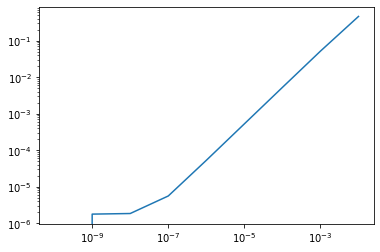

In [44]:
plt.plot(epsilons, sol_norms)
plt.yscale("log")
plt.xscale("log")
# Almost linear relation betwen value of epsilon and how far the solution is from 0

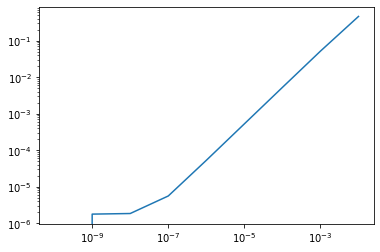

In [45]:
plt.plot(epsilons, sol_norms)
plt.yscale("log")
plt.xscale("log")

In [81]:
'sd' in 'fdsasd'

True